In [1]:
# %load_ext autoreload
# %autoreload 2

## About this notebook
In this notebook, we show how one can analyze the results from Careless. We do so using the results from a run scaling and merging the same XFEL dataset described under "Merging serial crystallography from a free electron laser". For this run, we asked Careless to also generate two additional outputs (these are optional but help assess performance).

### Merging randomly-split data
Internal consistency of the merging results is generally a good indicator of data quality, as it reports on amount of random error in the scaled error. Using ```--merge-half-datasets``` and ```--half-dataset-repeats=3```, Careless will globally estimate a scale function and then separately infer structure factor amplitudes based on observations in two randomly-split halves of the data. In this example, this is repeated three times. The resulting MTZ file (```thermolysin_xval_0.mtz```) therefore contains merged structure factor amplitudes for different halves (```half``` column) and repeats (```repeat``` column). This output is suitable for the calculation of different measures of the internal consistency of the merging results, including $CC_{1/2}$ and $R_{split}$. A separate measure, $CC_{anom}$ reports on the consistency of anomalous signal.

### Out-of-sample prediction
In any scaling approach, differences in intensities between nearby observations (e.g. on an image or along a rotation series) are due to a combination of changes in the underlying structure factor amplitudes and in the "scale" of the observation--an account for changes in diffraction volume, absorption, radiation damage, and other factors. The challenge is to optimally explain these differences in terms of differences in scale and structure factor amplitudes. To guard against overfitting--assigning too much of the variation to changes in scale, Careless supports use of a test set for cross validation. 

Using the flag ```--test-fraction=0.1``` we prompt Careless to generate an extra MTZ file (```thermolysin_predictions_0.mtz```) in which part of the data (here, 10%) has been held out as a test set. For both the data used in training the scale function (the ''training data'') and the data not used for that purpose (the ''test set''), Careless will generate predictions based on the estimated scale function and structure factor amplitudes. The correlation between the observed and predicted intensities for the training set provides a measure of fit for the data; the gap between the training set and the test set provides a measure of the degree to which the scale function overfits the data.

### Python packages used in this analysis
Throughout, we will use two freely-available open-source python packages developed in our group, ```reciprocalspaceship``` which enables us to work with crystallographic data from MTZs, CrystFEL stream files, etc., as ```DataSet``` objects. These ```DataSet``` objects are derived from ```pandas``` and ```GEMMI``` and are described in more detail at  https://hekstra-lab.github.io/reciprocalspaceship/. In addition, we use the ```rs-booster``` to perform analyses on these datasets (see https://github.com/rs-station/rs-booster).

In [2]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import reciprocalspaceship as rs
from rsbooster.stats import cchalf, ccanom, ccpred, rsplit, summary_stats 

plt.rcParams.update({'font.size': 14}) 

In [3]:
mtz_path="/n/home12/dhekstra/merge_eo_fast/"

nbins=10
custom_range = sorted([0.0,100.], key=float) # change this if you want to truncate the data
custom_shell = sorted([1.9, 2.0], key=float) # change this to also get results for a specific res. range

## Dataset statistics
Let's examine the dataset. 

Note that the fully merged output files of Careless have the format ```prefix_#.mtz```, where ```#``` is a serial number corresponding to the order in which input MTZs were listed in the Careless call (as long as Careless was called with the ```--separate-files``` flag or only one output was produced)

In [4]:
mtz="thermolysin_0.mtz"
ds =rs.read_mtz(mtz_path+mtz)

# adds the resolution for each hkl
ds.compute_dHKL(inplace=True) 
ds=ds.loc[(ds.dHKL>=custom_range[0]) & (ds.dHKL< custom_range[1]),ds.columns]
ds, labels = ds.assign_resolution_bins(nbins) # adds resolution bins

labels=rs.DataSet(data={"res. (A)": labels})
labels.loc[nbins, "res. (A)"]="Overall"

print(f"The dataset contains {len(ds):,} rows.\n")
ds.head()

The dataset contains 31,703 rows.



F(+)     SigF(+)      F(-)     SigF(-)  N(+)  N(-)       high(+)  \
H K L                                                                          
0 0 6   3.363971  0.03068459  3.363971  0.03068459  88.0  88.0 10000000000.0   
    12  8.822804 0.018236266  8.822804 0.018236266  37.0  37.0 10000000000.0   
    18 3.4268532  0.02938392 3.4268532  0.02938392  26.0  26.0 10000000000.0   
    24 1.3171281 0.042567454 1.3171281 0.042567454  14.0  14.0 10000000000.0   
    30 6.9339495 0.017228445 6.9339495 0.017228445  13.0  13.0 10000000000.0   

          loc(+)  low(+)    scale(+)       high(-)    loc(-)  low(-)  \
H K L                                                                  
0 0 6   3.363971     0.0  0.03068459 10000000000.0  3.363971     0.0   
    12  8.822804     0.0 0.018236266 10000000000.0  8.822804     0.0   
    18 3.4268532     0.0  0.02938392 10000000000.0 3.4268532     0.0   
    24 1.3171281     0.0 0.042567454 10000000000.0 1.3171281     0.0   
    30 6.9339495     0.0 0.017228445 10000000000.0 6.9339495     0.0   

          scale(-)      dHKL  bin  
H K L                              
0 0 6   0.03068459 21.784466    0  
    12 0.018236266 10.892233    0  
    18  0.02938392  7.261489    0  
    24 0.042567454 5.4461164    0  
    30 0.017228445 4.3568935    0

### Completeness

In [5]:
completeness=rs.stats.completeness.compute_completeness(ds,bins=nbins, anomalous=True)
completeness.head(nbins+1)

completeness                        
                      all non-anomalous anomalous
34.35 - 3.99     1.000000      1.000000  1.000000
3.99 - 3.13      1.000000      1.000000  1.000000
3.13 - 2.72      1.000000      1.000000  1.000000
2.72 - 2.47      1.000000      1.000000  1.000000
2.47 - 2.28      1.000000      1.000000  1.000000
2.28 - 2.14      1.000000      1.000000  1.000000
2.14 - 2.03      0.999665      1.000000  0.999644
2.03 - 1.94      0.997665      1.000000  0.997524
1.94 - 1.87      0.986222      0.998111  0.986126
1.87 - 1.80      0.937111      0.986003  0.938257
overall          0.991805      0.998394  0.991687

### Multiplicity
Let's determine the multiplicity (of observations) for each _hkl_. Keep in mind that in the previous step we did not merge Friedel mates--we just reformatted the table so they are separate entries.

Since these data contain separate columns for Friedel mates, we want to "stack" them for the next steps.

In [6]:
multiplicity = summary_stats.calculate_multiplicity(ds)
multiplicity = rs.concat([labels, multiplicity],axis=1,check_isomorphous=False).set_index("res. (A)")
multiplicity.head(nbins+1)

,multiplicity
res. (A),
34.35 - 3.99,40.250324
3.99 - 3.13,25.009539
3.13 - 2.72,21.102121
2.72 - 2.47,18.598442
2.47 - 2.28,18.698093
2.28 - 2.14,16.395941
2.14 - 2.03,11.94728
2.03 - 1.94,7.448605
1.94 - 1.87,5.151255


### Signal-to-noise ratio
Let's calculate the signal-to-noise ratio of each merged structure factor amplitude. 

Note: this adds a "F/sigF" column to our DataSet.

In [7]:
FsigF = summary_stats.calculate_FsigF(ds)
print("Average F/sigF by resolution bin: \n")

FsigF = rs.concat([labels, FsigF],axis=1,check_isomorphous=False).set_index("res. (A)")
FsigF.head(nbins+1)

Average F/sigF by resolution bin: 



,<F/SigF>merged
res. (A),
34.35 - 3.99,553.330505
3.99 - 3.13,412.141174
3.13 - 2.72,258.086182
2.72 - 2.47,179.99234
2.47 - 2.28,144.854858
2.28 - 2.14,105.866127
2.14 - 2.03,72.281296
2.03 - 1.94,42.392761
1.94 - 1.87,26.706434


Keep in mind that 
$$
\frac{I}{\sigma(I)} \approx \frac{1}{2} \frac{F}{\sigma(F)}
$$

## Half-dataset statistics
Cross-validation are stored in files ending in ```xval_#.mtz```, where ```#``` refers to a serial number.

In [8]:
mtz_xval="thermolysin_xval_0.mtz"
ds_xval=rs.read_mtz(mtz_path+mtz_xval)
ds_xval.compute_dHKL(inplace=True)
ds_xval, labels = ds_xval.assign_resolution_bins(nbins) 
ds_xval=ds_xval.loc[(ds_xval.dHKL>=custom_range[0]) &\
                    (ds_xval.dHKL< custom_range[1]),ds_xval.columns]
ds_xval.head()

F(+)     SigF(+)      F(-)     SigF(-)  N(+)  N(-)       high(+)  \
H K L                                                                          
0 0 6   3.112976 0.014908171  3.112976 0.014908171  46.0  46.0 10000000000.0   
    12  9.794577 0.024063408  9.794577 0.024063408  22.0  22.0 10000000000.0   
    18  4.112734 0.014832605  4.112734 0.014832605  12.0  12.0 10000000000.0   
    24 1.6162362   0.0270514 1.6162362   0.0270514   7.0   7.0 10000000000.0   
    30  7.417462 0.021880211  7.417462 0.021880211   8.0   8.0 10000000000.0   

          loc(+)  low(+)    scale(+)       high(-)    loc(-)  low(-)  \
H K L                                                                  
0 0 6   3.112976     0.0 0.014908171 10000000000.0  3.112976     0.0   
    12  9.794577     0.0 0.024063408 10000000000.0  9.794577     0.0   
    18  4.112734     0.0 0.014832605 10000000000.0  4.112734     0.0   
    24 1.6162362     0.0   0.0270514 10000000000.0 1.6162362     0.0   
    30  7.417462     0.0 0.021880211 10000000000.0  7.417462     0.0   

          scale(-)  repeat  half      dHKL  bin  
H K L                                            
0 0 6  0.014908171       0     0 21.784466    0  
    12 0.024063408       0     0 10.892233    0  
    18 0.014832605       0     0  7.261489    0  
    24   0.0270514       0     0 5.4461164    0  
    30 0.021880211       0     0 4.3568935    0

### CC1/2
Let's calculate CC1/2. ```rs-booster``` supports calculation of the "normal" correlation coefficient, the Pearson correlation coefficient, and the Spearman correlation coefficient---a robust alternative that is not sensitive to ourliers. We recommend the Spearman CC1/2.

In [9]:
method="pearson" # try "pearson" or "spearman"
# the following already stacks if necessary:
results,labels=cchalf.analyze_cchalf_mtz(ds_xval, bins=nbins, return_labels=True, method=method)

cc_half=results.copy()
cc_half["CChalf"]=cc_half[("F1", "F2")].astype(float)
cc_half["bin"]=cc_half["bin"].astype(int)
cc_half.drop(columns=[("F1", "F2")],inplace=True)

# switch to better formatting
cc_half_report = summary_stats.parse_xval_stats(results, labels, nbins=nbins)
cc_half_report.head(nbins+1)

,"(0, CChalf, )","(1, CChalf, )","(2, CChalf, )","(avg, CChalf, )"
Res. bin (A),,,,
34.35 - 3.90,0.968019,0.967494,0.967255,0.967589
3.90 - 3.09,0.963833,0.964140,0.963985,0.963986
3.09 - 2.70,0.950649,0.951646,0.948879,0.950391
2.70 - 2.45,0.933917,0.936608,0.933847,0.934791
2.45 - 2.28,0.897310,0.892810,0.893713,0.894611
2.28 - 2.14,0.874538,0.865976,0.871583,0.870699
2.14 - 2.04,0.767269,0.774228,0.769720,0.770406
2.04 - 1.95,0.487588,0.518252,0.483140,0.496327
1.95 - 1.87,0.340134,0.320103,0.340080,0.333439


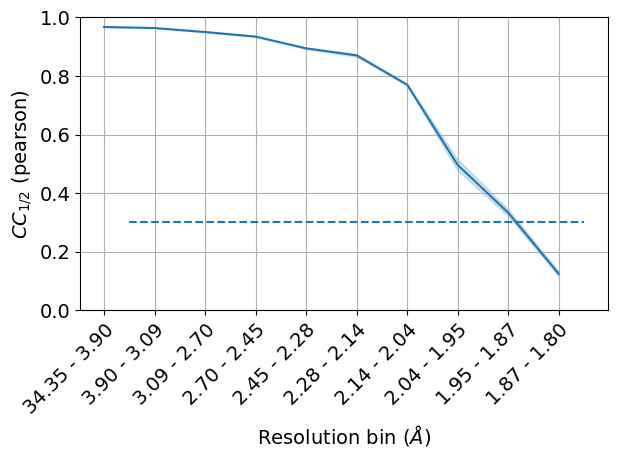

In [10]:
sns.lineplot(data=cc_half.loc[cc_half.bin < nbins,], x="bin", y="CChalf",errorbar='sd')
plt.hlines(0.3,xmin=0.5,xmax=nbins-0.5,linestyles='--')
plt.xticks(range(nbins), labels[0:nbins], rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel(r"Resolution bin $(\AA$)")
plt.ylabel(r"$CC_{1/2}$ " + f"({method})")
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.show()

### CCanom
Let's look at the apparent anomalous signal in the dataset by $CC_{anom}$. Note that some programs report weighted $CC_{anom}$, which tend to be larger!

In [11]:
# This calculation requires unstacked anomalous observations
# stack/unstack is not quite reversible, so it is simpler to read this in again from scratch.
results, labels = ccanom.analyze_ccanom_mtz(ds_xval, bins=nbins, return_labels=True, method="spearman")

cc_anom=results.copy()
cc_anom.bin=cc_anom.bin.astype(int)
cc_anom["CCanom"] = cc_anom[("DF1", "DF2")].astype(float)
cc_anom.drop(columns=[("DF1", "DF2")], inplace=True)

# switch to better formatting
cc_anom_report = summary_stats.parse_xval_stats(results, labels, nbins=nbins, name="CCanom")
cc_anom_report.head(nbins+1)

cc_anom.head()

,bin,repeat,CCanom
,,,
0,0,0,0.139136
1,0,1,0.094627
2,0,2,0.111940
3,1,0,0.036791
4,1,1,0.065556


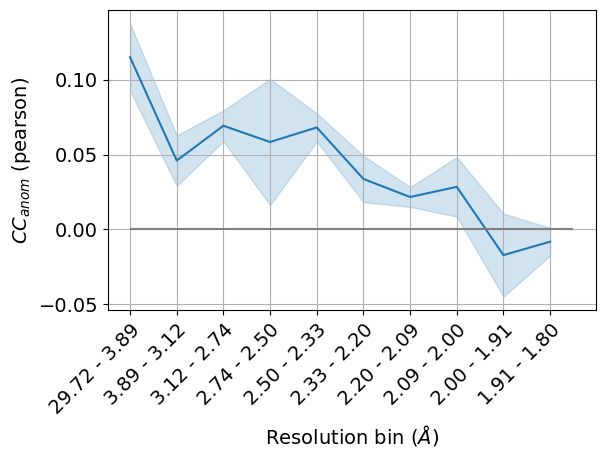

In [12]:
sns.lineplot(data=cc_anom.loc[cc_anom.bin < nbins,], x="bin", y="CCanom",errorbar='sd')
xl=plt.xlim()
plt.hlines(y=0,xmin=0,xmax=nbins-0.5,color='gray')
plt.xticks(range(nbins), labels[:nbins], rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel(r"Resolution bin $(\AA$)")
plt.ylabel(r"$CC_{anom}$ " + f"({method})")
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid()
plt.tight_layout()
plt.show()

We see that there is detectable anomalous signal out to 2.0 A, but anomalous signal is generally quite weak!

### Rsplit calculation
This is not our favorite statistic, because it is not robust to linear changes in scale of halves of the dataset. See also http://scripts.iucr.org/cgi-bin/paper?S205979831801238X.

In [13]:
results,labels=rsplit.analyze_rsplit_mtz(ds_xval, generate_I=True, by_bin=True)
r_split=results.copy()

# switch to better formatting
r_split_report = summary_stats.parse_xval_stats(results, labels, nbins=nbins, name="Rsplit")
r_split_report.head(nbins+1)

,"(0, Rsplit)","(1, Rsplit)","(2, Rsplit)","(avg, Rsplit)"
Res. bin (A),,,,
34.35 - 3.90,0.107209,0.108717,0.108818,0.108248
3.90 - 3.09,0.125268,0.123924,0.124353,0.124515
3.09 - 2.70,0.240341,0.246089,0.240857,0.242429
2.70 - 2.45,0.147564,0.147388,0.149899,0.148284
2.45 - 2.28,0.178579,0.174698,0.176685,0.176654
2.28 - 2.14,0.206010,0.207627,0.206040,0.206559
2.14 - 2.04,0.319066,0.315268,0.320600,0.318312
2.04 - 1.95,0.494692,0.477240,0.497760,0.489897
1.95 - 1.87,0.607282,0.621553,0.601954,0.610263


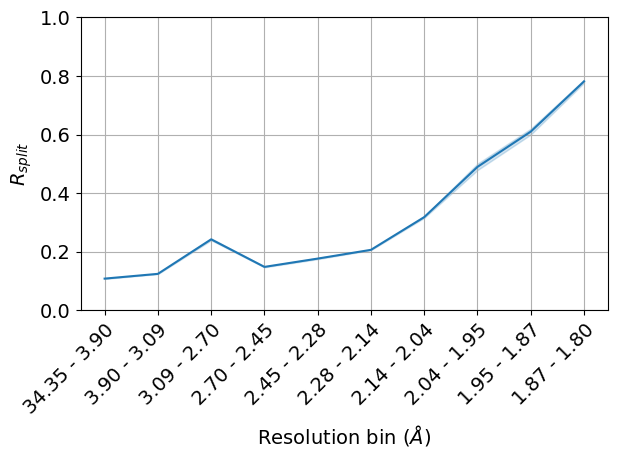

In [14]:
sns.lineplot(data=r_split.loc[r_split.bin<nbins,], x="bin", y="Rsplit",errorbar='sd')
plt.xticks(range(10), labels[:nbins], rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel(r"Resolution bin $(\AA$)")
plt.ylabel(r"$R_{split}$")
# plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.show()

## Checking for overfitting

In [15]:
mtz_pred="thermolysin_predictions_0.mtz"
ds_pred=rs.read_mtz(mtz_path+mtz_pred)
ds_pred.compute_dHKL(inplace=True)
ds_pred, labels = ds_pred.assign_resolution_bins(nbins) 
ds_pred=ds_pred.loc[(ds_pred.dHKL>=custom_range[0]) & (ds_pred.dHKL< custom_range[1]),ds_pred.columns]

ds_pred.head()
# we do not need to unstack anomalous because each reflection is represented with its original hkl

Iobs   SigIobs      Ipred  SigIpred  test  PARTIAL      dHKL  bin
H  K L                                                                        
37 4 18  100.0531 37.407852   70.50218  2.682555     0    False 1.9838704    9
35 4 25 230.70123  33.55069 110.899956 12.481149     0    False 2.0064795    9
   3 19 254.54163 40.807156  212.21463 4.5246964     0    False 2.1012225    8
   2 2  -52.80359  41.45886  120.34781 3.1072774     0    False 2.2390797    7
     3  -59.73877 46.124752  113.21233 1.9543839     0    False  2.237439    7

In [66]:
tmp=ds_pred.reset_index()

It is interesting to observe that the Miller indices here are those of the 'anomalous' asymmetric unit: the usual ASU and the ASU containing its Friedel mates:

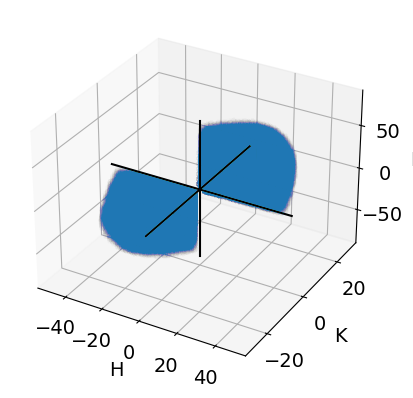

In [67]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(tmp.H, tmp.K, tmp.L, 'bo',alpha=0.002)
ax.plot3D(xs=ax.get_xlim(),ys=[0,0],zs=[0,0],color='k')
ax.plot3D(xs=[0,0],ys=ax.get_ylim(),zs=[0,0],color='k')
ax.plot3D(xs=[0,0],ys=[0,0],zs=ax.get_zlim(),color='k')
ax.set_xlabel('H')
ax.set_ylabel('K')
ax.set_zlabel('L')
plt.show()

In [16]:
cc_pred, labels = ccpred.compute_ccpred(mtz_path+mtz_pred)
cc_pred["CCpred"] = cc_pred[("Iobs", "Ipred")]
cc_pred.head()

,bin,test,Iobs,id,delay,spacegroup,CCpred
,,,Ipred,,,,
0,0,0,0.929030,,0,P 61 2 2,0.929030
1,0,1,0.911811,,0,P 61 2 2,0.911811
2,1,0,0.934511,,0,P 61 2 2,0.934511
3,1,1,0.928684,,0,P 61 2 2,0.928684
4,2,0,0.938753,,0,P 61 2 2,0.938753


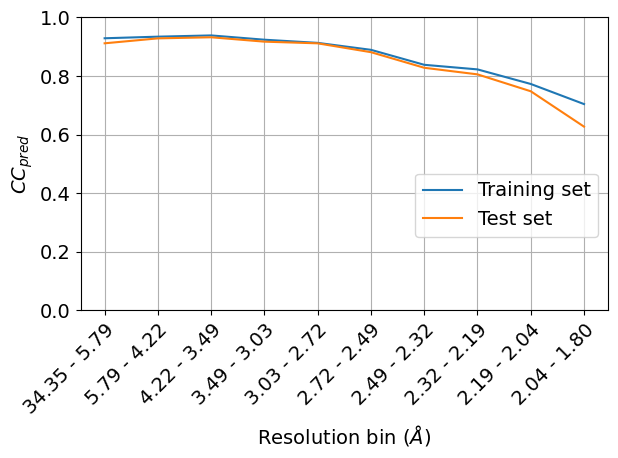

In [17]:
plt.plot(cc_pred.loc[(cc_pred.test==0) & (cc_pred.bin<nbins),"bin"], \
         cc_pred.loc[(cc_pred.test==0) & (cc_pred.bin<nbins),"CCpred"],label="Training set")
plt.plot(cc_pred.loc[(cc_pred.test==1) & (cc_pred.bin<nbins),"bin"], \
         cc_pred.loc[(cc_pred.test==1) & (cc_pred.bin<nbins),"CCpred"],label="Test set")
plt.xticks(range(nbins), labels[:nbins], rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel(r"Resolution bin $(\AA$)")
plt.ylabel(r"$CC_{pred}$")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.show()